<a href="http://cocl.us/pytorch_link_top">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/Pytochtop.png" width="750" alt="IBM Product " />
</a> 

<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/cc-logo-square.png" width="200" alt="cognitiveclass.ai logo" />

<h1><h1>Pre-trained-Models with PyTorch </h1>

In this lab, you will use pre-trained models to classify between the negative and positive samples; you will be provided with the dataset object. The particular pre-trained model will be resnet18; you will have three questions: 
<ul>
<li>change the output layer</li>
<li> train the model</li> 
<li>  identify  several  misclassified samples</li> 
 </ul>
You will take several screenshots of your work and share your notebook. 

<h2>Table of Contents</h2>

<div class="alert alert-block alert-info" style="margin-top: 20px">


<ul>
    <li><a href="#download_data"> Download Data</a></li>
    <li><a href="#auxiliary"> Imports and Auxiliary Functions </a></li>
    <li><a href="#data_class"> Dataset Class</a></li>
    <li><a href="#Question_1">Question 1</a></li>
    <li><a href="#Question_2">Question 2</a></li>
    <li><a href="#Question_3">Question 3</a></li>
</ul>
<p>Estimated Time Needed: <strong>120 min</strong></p>
 </div>
<hr>

<h2 id="download_data">Download Data</h2>

Download the dataset and unzip the files in your data directory, unlike the other labs, all the data will be deleted after you close  the lab, this may take some time:

In [1]:
# !wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip 

--2020-03-30 08:57:31--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2598656062 (2.4G) [application/zip]
Saving to: ‘Positive_tensors.zip’

Positive_tensors.zi 100%[===================>]   2.42G  10.8MB/s    in 5m 53s  

2020-03-30 09:03:24 (7.03 MB/s) - ‘Positive_tensors.zip’ saved [2598656062/2598656062]



In [2]:
# !unzip -q Positive_tensors.zip 

In [5]:
# !wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip

# !unzip -q Negative_tensors.zip

--2020-03-30 09:11:55--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2111408108 (2.0G) [application/zip]
Saving to: ‘Negative_tensors.zip’

Negative_tensors.zi 100%[===================>]   1.97G  8.20MB/s    in 4m 52s  

2020-03-30 09:16:48 (6.91 MB/s) - ‘Negative_tensors.zip’ saved [2111408108/2111408108]



We will install torchvision:

In [ ]:
# !pip install torchvision

<h2 id="auxiliary">Imports and Auxiliary Functions</h2>

The following are the libraries we are going to use for this lab. The <code>torch.manual_seed()</code> is for forcing the random function to give the same number every time we try to recompile it.

In [1]:
# These are the libraries will be used for this lab.
import torchvision.models as models
from PIL import Image
import pandas

from torchvision import transforms
import torch.nn as nn
import time
import torch 
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob

torch.manual_seed(0)

In [2]:
from matplotlib.pyplot import imshow
# import matplotlib.pylab as plt
# from PIL import Image
import pandas as pd
import os

<!--Empty Space for separating topics-->

<h2 id="data_class">Dataset Class</h2>

This dataset class is essentially the same dataset you build in the previous section, but to speed things up, we are going to use tensors instead of jpeg images. **Therefore for each iteration, you will skip the reshape step, conversion step to tensors and normalization step.**

In [3]:
## Create your own dataset object

class Dataset(Dataset):
    ## Constructor
    def __init__(self, transform=None, train=True):
        directory = "./" # "/home/dsxuser/work"
        positive  = 'Positive_tensors'
        negative  = 'Negative_tensors'

        positive_file_path = os.path.join(directory,positive)
        negative_file_path = os.path.join(directory,negative)
        positive_files = [os.path.join(positive_file_path,file) \
                          for file in os.listdir(positive_file_path) if file.endswith(".pt")]
        negative_files = [os.path.join(negative_file_path,file) \
                          for file in os.listdir(negative_file_path) if file.endswith(".pt")]
        number_of_samples = len(positive_files) + len(negative_files)
        self.all_files = [None] * number_of_samples
        self.all_files[::2]  = positive_files
        self.all_files[1::2] = negative_files 
        
        self.transform = transform # The transform is goint to be used on image
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor) # torch.LongTensor
        self.Y[::2]  = 1
        self.Y[1::2] = 0
        
        if train:
            self.all_files = self.all_files[0:30000]
            self.Y = self.Y[0:30000]    
        else:
            self.all_files = self.all_files[30000:]
            self.Y = self.Y[30000:]
        self.len = len(self.all_files)
       
    ## Get the length
    def __len__(self):
        return self.len
    
    ## Getter
    def __getitem__(self, ix):
        image = torch.load(self.all_files[ix])
        y = self.Y[ix]      
        # # If there is any transform method, apply it onto the image
        if self.transform: image = self.transform(image)
        return image, y

print("done")

done


We create two dataset objects, one for the training data and one for the validation data.

In [4]:
train_dataset = Dataset(train=True)
validation_dataset = Dataset(train=False)
print("done")

done


<h2 id="Question_1">Question 1</h2>

<b>Prepare a pre-trained resnet18 model :</b>

<b>Step 1</b>: Load the pre-trained model <code>resnet18</code> Set the parameter <code>pretrained</code> to true:

In [5]:
## Type your code here

model = models.resnet18(pretrained=True)

<b>Step 2</b>: Set the attribute <code>requires_grad</code> to <code>False</code>. As a result, the parameters will not be affected by training.

In [6]:
## Type your code here

for parm in model.parameters(): parm.requires_grad = False

<b>Step 3</b>: Replace the output layer <code>model.fc</code> of the neural network with a <code>nn.Linear</code> object, to classify 2 different classes. For the parameters <code>in_features </code> remember the last hidden layer has 512 neurons.

In [7]:
## Type your code here

model.fc = nn.Linear(in_features=512, out_features=2) # nn.Linear(512, 2)

Print out the model in order to show whether you get the correct answer.<br> <b>(Your peer reviewer is going to mark based on what you print here.)</b>

In [8]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<h2 id="Question_2">Question 2: Train the Model</h2>

In this question you will train your, model:

<b>Step 1</b>: Create a cross entropy criterion function 

In [9]:
## Type your code here

criterion = nn.CrossEntropyLoss()

<b>Step 2</b>: Create a training loader and validation loader object, the batch size should have 100 samples each.

In [10]:
## Type your code here

training_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
                                              # shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100)
                                                # shuffle=False)

<b>Step 3</b>: Use the following optimizer to minimize the loss 

In [11]:
optimizer = torch.optim.Adam([parameters for parameters in model.parameters() \
                              if parameters.requires_grad], lr=0.001)

<!--Empty Space for separating topics-->

**Complete the following code to calculate  the accuracy on the validation data for one epoch; this should take about 45 minutes.**  
**Make sure you calculate the accuracy on the validation data.**

In [12]:
n_epochs = 1
loss_list, accuracy_list = [], []
n_val = len(validation_dataset)
# n_train = len(train_dataset)
start_time = time.time()
loss = 0

for epoch in range(n_epochs):
    for x, y in training_loader:
        model.train() 
        optimizer.zero_grad()   # clear gradient 
        z = model(x)            # make a prediction 
   
        loss = criterion(z, y)  # calculate loss 
        loss.backward()         # calculate gradients of parameters 
        optimizer.step()        # update parameters 
        
        loss_list.append(loss.data)
        
    correct = 0
    for x_val, y_val in validation_loader:
        model.eval()                             # set model to eval 
        z = model(x_val)                         # make a prediction 
        
        _, y_hat = torch.max(z, 1)               # find max 
        correct += (y_hat == y_val).sum().item() # Calculate misclassified  samples in mini-batch 
        
    accuracy = correct / n_val
    print("Epoch {:2d} - Time: {:3.5f}s / Accuracy: {:2.5f}".format(epoch + 1, 
                                                                    time.time() - start_time, 
                                                                    accuracy))

Epoch  1 - Time: 720.67477s / Accuracy: 0.99330


<b>Print out the Accuracy and plot the loss stored in the list <code>loss_list</code> for every iteration and take a screen shot.</b>

In [13]:
accuracy

0.9933

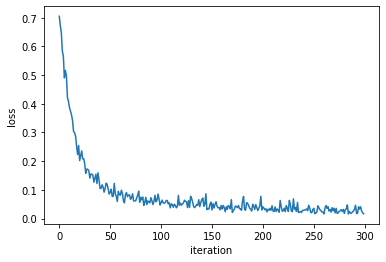

In [14]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

<h2 id="Question_3">Question 3: Find the misclassified samples</h2> 

<b>Identify the first four misclassified samples using the validation data:</b>

In [44]:
def find_misclassified(validation_loader):
    samples = []
    n_batch = 0
    for x_val, y_val in validation_loader:     
        model.eval()                           # set model to eval 
        z = model(x_val)                       # make a prediction 
        _, y_hat = torch.max(z, 1)
  
        for ix in range(0, len(y_hat)):
            if (y_hat[ix] != y_val[ix]):
                sample_num = n_batch + ix
                samples.append({'snum': sample_num, 'x': x_val[ix], 'y_val': y_val[ix], 'y_hat': y_hat[ix]})
            if len(samples) >= 4: return samples
        n_batch += len(y_val)                  # batch of 100

    return samples

In [45]:
samples = find_misclassified(validation_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


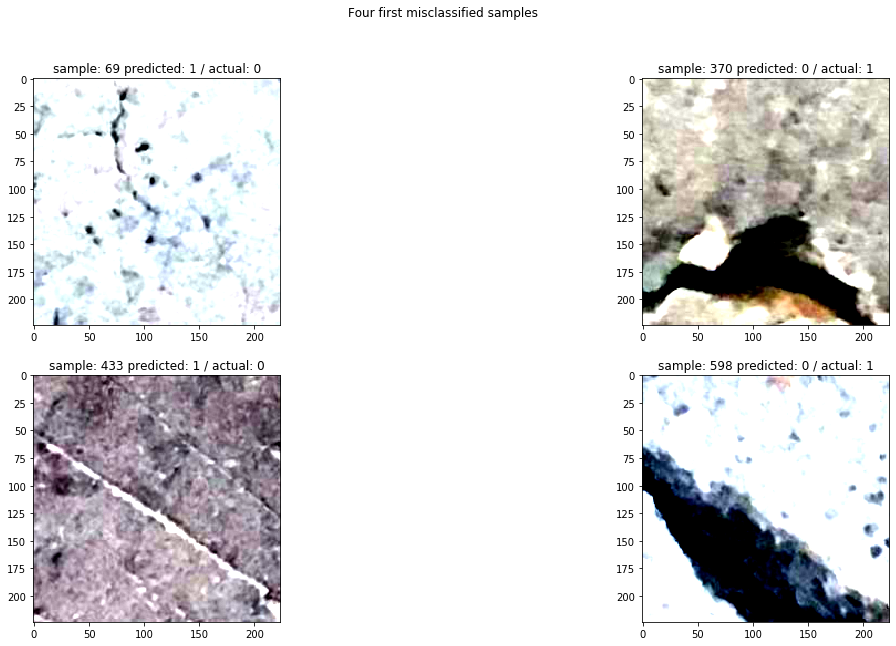

In [46]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

ix = 0
for ax1 in axs:
    for ax2 in ax1:
        sample = samples[ix]
        ax2.imshow(sample['x'].permute(1, 2, 0).numpy())
        ax2.title.set_text("sample: " + str(sample['snum']) + " predicted: " + str(sample['y_hat'].item()) + \
                           " / actual: " + str(sample['y_val'].item()))
        ix += 1
        
fig.suptitle('Four first misclassified samples') 
plt.show()

<a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/share-notebooks.html"> CLICK HERE </a> Click here to see how to share your notebook.

<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.

Copyright &copy; 2018 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.